In [31]:
import xarray as xr

# Load the predictions
ds_pred = xr.open_dataset('drought-forecasting/modeling-pipeline/data/07_model_output/predictions.nc')

In [32]:
ds_pred

<xarray.Dataset> Size: 330MB
Dimensions:        (forecast_time: 106, horizon: 6, latitude: 180,
                    longitude: 360)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 848B 2014-09-01 ... 2023-06-01
  * horizon        (horizon) int64 48B 1 2 3 4 5 6
  * latitude       (latitude) int64 1kB -90 -89 -88 -87 -86 ... 85 86 87 88 89
  * longitude      (longitude) int64 3kB 0 1 2 3 4 5 ... 354 355 356 357 358 359
Data variables:
    y              (forecast_time, horizon, latitude, longitude) float32 165MB ...
    y_hat          (forecast_time, horizon, latitude, longitude) float32 165MB ...

In [11]:
import torch
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from typing import Any, Optional

# Additional imports for country boundaries:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_full_horizon(
    ds: xr.Dataset,
    forecast_time: Optional[str] = None,
    y_hat: str = "y_hat",
    y: str = "y",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    colormap: str = "custom"
) -> Any:
    """
    Visualize y_hat and y_true for all horizon steps for a specific forecast_time
    using a selectable color scale. The maps are projected with PlateCarree and
    country boundaries/coastlines are added via Cartopy.

    Args:
        ds (xarray.Dataset):
            The dataset containing the specified 'y' and 'y_hat' variables with dimensions:
            (forecast_time, horizon, latitude, longitude).
        forecast_time (str, optional):
            Date (in 'YYYY-MM-DD' format) of the forecast_time coordinate to visualize.
            Defaults to None, which selects the first forecast_time.
        y_hat (str, optional):
            Name of the variable representing model predictions. Defaults to "y_hat".
        y (str, optional):
            Name of the variable representing ground truth. Defaults to "y".
        vmin (float, optional):
            Minimum value for color scaling.
            If None, it is inferred from the data. Defaults to None.
        vmax (float, optional):
            Maximum value for color scaling.
            If None, it is inferred from the data. Defaults to None.
        colormap (str, optional):
            Colormap for visualization.
            - If "custom", uses a custom boundary-based colormap
              (red → orange → green → lightblue → blue).
            - Otherwise, uses a built-in Matplotlib colormap
              (e.g. "RdBu", "viridis", "coolwarm").
            Defaults to "custom".

    Returns:
        Any:
            The resulting figure with subplots showing y_hat and y_true for each horizon step.

    Raises:
        ValueError:
            If the dataset does not contain the specified 'y' or 'y_hat' variables.
        ValueError:
            If the provided forecast_time is not found in the dataset.
    """
    # --- Validate dataset ---
    if not {y, y_hat}.issubset(ds.variables):
        raise ValueError(f"The dataset must contain '{y}' and '{y_hat}' variables.")

    # --- Validate and get the forecast_time index ---
    if forecast_time is not None:
        try:
            forecast_time_idx = np.where(ds.forecast_time == np.datetime64(forecast_time))[0][0]
        except IndexError:
            raise ValueError(f"The provided forecast_time '{forecast_time}' is not found in the dataset.")
    else:
        forecast_time_idx = 0  # Default to the first forecast_time

    # --- Select colormap and normalization approach ---
    if colormap == "custom":
        custom_boundaries = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        custom_colors = ["red", "orange", "green", "green", "lightblue", "blue"]
        cmap = ListedColormap(custom_colors)
        norm = BoundaryNorm(custom_boundaries, cmap.N)
        boundaries = custom_boundaries
    else:
        cmap = plt.get_cmap(colormap)
        norm = None
        boundaries = None

    # --- Extract data for the given forecast_time ---
    y_hat_all_steps = ds[y_hat].isel(forecast_time=forecast_time_idx).values
    y_true_all_steps = ds[y].isel(forecast_time=forecast_time_idx).values

    # --- Coordinates ---
    lats = ds.latitude.values
    lons = ds.longitude.values
    forecast_time_val = pd.to_datetime(ds.forecast_time.values[forecast_time_idx])

    # Calculate the start date (11 months before forecast_time_val)
    start_date = forecast_time_val - pd.DateOffset(months=11)

    # Format the dates
    start_str = start_date.strftime("%Y-%m")
    end_str = forecast_time_val.strftime("%Y-%m")

    # Define the actual forecast dates based on horizon
    horizon_steps = ds.horizon.values
    forecast_dates = [
        forecast_time_val + pd.DateOffset(months=int(step)) for step in horizon_steps
    ]

    # Shift longitude from [0, 360] to [-180, 180] if necessary
    lons_shifted = np.where(lons > 180, lons - 360, lons)

    # Sort the longitudes and corresponding data
    sorted_indices = np.argsort(lons_shifted)
    lons_sorted = lons_shifted[sorted_indices]

    # Compute vmin/vmax if not provided
    if vmin is None:
        vmin = min(np.nanmin(y_hat_all_steps), np.nanmin(y_true_all_steps))
    if vmax is None:
        vmax = max(np.nanmax(y_hat_all_steps), np.nanmax(y_true_all_steps))

    # --- Use Cartopy for plotting with country boundaries ---
    projection = ccrs.PlateCarree(central_longitude=0)
    fig, axes = plt.subplots(
        nrows=len(horizon_steps),
        ncols=2,
        subplot_kw={"projection": projection},
        figsize=(14, 4 * len(horizon_steps)),
        constrained_layout=True
    )
    fig.suptitle(
        f"Total precipitation in millimeters\n1 mm = 10 liters of water per square meter\nForecasting based on {start_str} to {end_str}",
        fontsize=16,
        fontweight="bold"
    )

    # --- Plot each horizon step ---
    for step in range(len(horizon_steps)):
        # Extract data for the current horizon step
        y_hat_map = y_hat_all_steps[step]
        y_true_map = y_true_all_steps[step]
        forecast_date_str = forecast_dates[step].strftime("%Y-%m")

        # Determine axes for single or multiple horizon steps
        if len(horizon_steps) == 1:
            ax_hat, ax_true = axes
        else:
            ax_hat = axes[step, 0]
            ax_true = axes[step, 1]

        # Add country boundaries and coastlines
        for ax in (ax_hat, ax_true):
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
            # Optionally add gridlines with labels
            gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
            gl.right_labels = False
            gl.top_labels = False

        # --- Plot y_hat ---
        mesh_hat = ax_hat.pcolormesh(
            lons_sorted,
            lats,
            y_hat_map[:, sorted_indices],
            cmap=cmap,
            norm=norm,
            vmin=vmin,
            vmax=vmax,
            shading="auto",
            transform=ccrs.PlateCarree()
        )
        ax_hat.set_title(f"{y_hat} - {forecast_date_str}", fontsize=14)

        # Add colorbar for y_hat on the first row
        if step == 0:
            if boundaries is not None:
                cbar_hat = plt.colorbar(
                    mesh_hat,
                    ax=ax_hat,
                    orientation="horizontal",
                    fraction=0.046,
                    pad=0.04,
                    boundaries=boundaries
                )
                cbar_hat.set_label(f"{y_hat} value in mm", fontsize=12)
                cbar_hat.set_ticks(boundaries)
                cbar_hat.set_ticklabels([f"{b:.1f}" for b in boundaries])
            else:
                cbar_hat = plt.colorbar(
                    mesh_hat,
                    ax=ax_hat,
                    orientation="horizontal",
                    fraction=0.046,
                    pad=0.04
                )
                cbar_hat.set_label(f"{y_hat} value in mm", fontsize=12)

        # --- Plot y_true ---
        mesh_true = ax_true.pcolormesh(
            lons_sorted,
            lats,
            y_true_map[:, sorted_indices],
            cmap=cmap,
            norm=norm,
            vmin=vmin,
            vmax=vmax,
            shading="auto",
            transform=ccrs.PlateCarree()
        )
        ax_true.set_title(f"{y} - {forecast_date_str}", fontsize=14)

        # Add colorbar for y_true on the first row
        if step == 0:
            if boundaries is not None:
                cbar_true = plt.colorbar(
                    mesh_true,
                    ax=ax_true,
                    orientation="horizontal",
                    fraction=0.046,
                    pad=0.04,
                    boundaries=boundaries
                )
                cbar_true.set_label(f"{y} value", fontsize=12)
                cbar_true.set_ticks(boundaries)
                cbar_true.set_ticklabels([f"{b:.1f}" for b in boundaries])
            else:
                cbar_true = plt.colorbar(
                    mesh_true,
                    ax=ax_true,
                    orientation="horizontal",
                    fraction=0.046,
                    pad=0.04
                )
                cbar_true.set_label(f"{y} value", fontsize=12)

    plt.show()
    # return fig


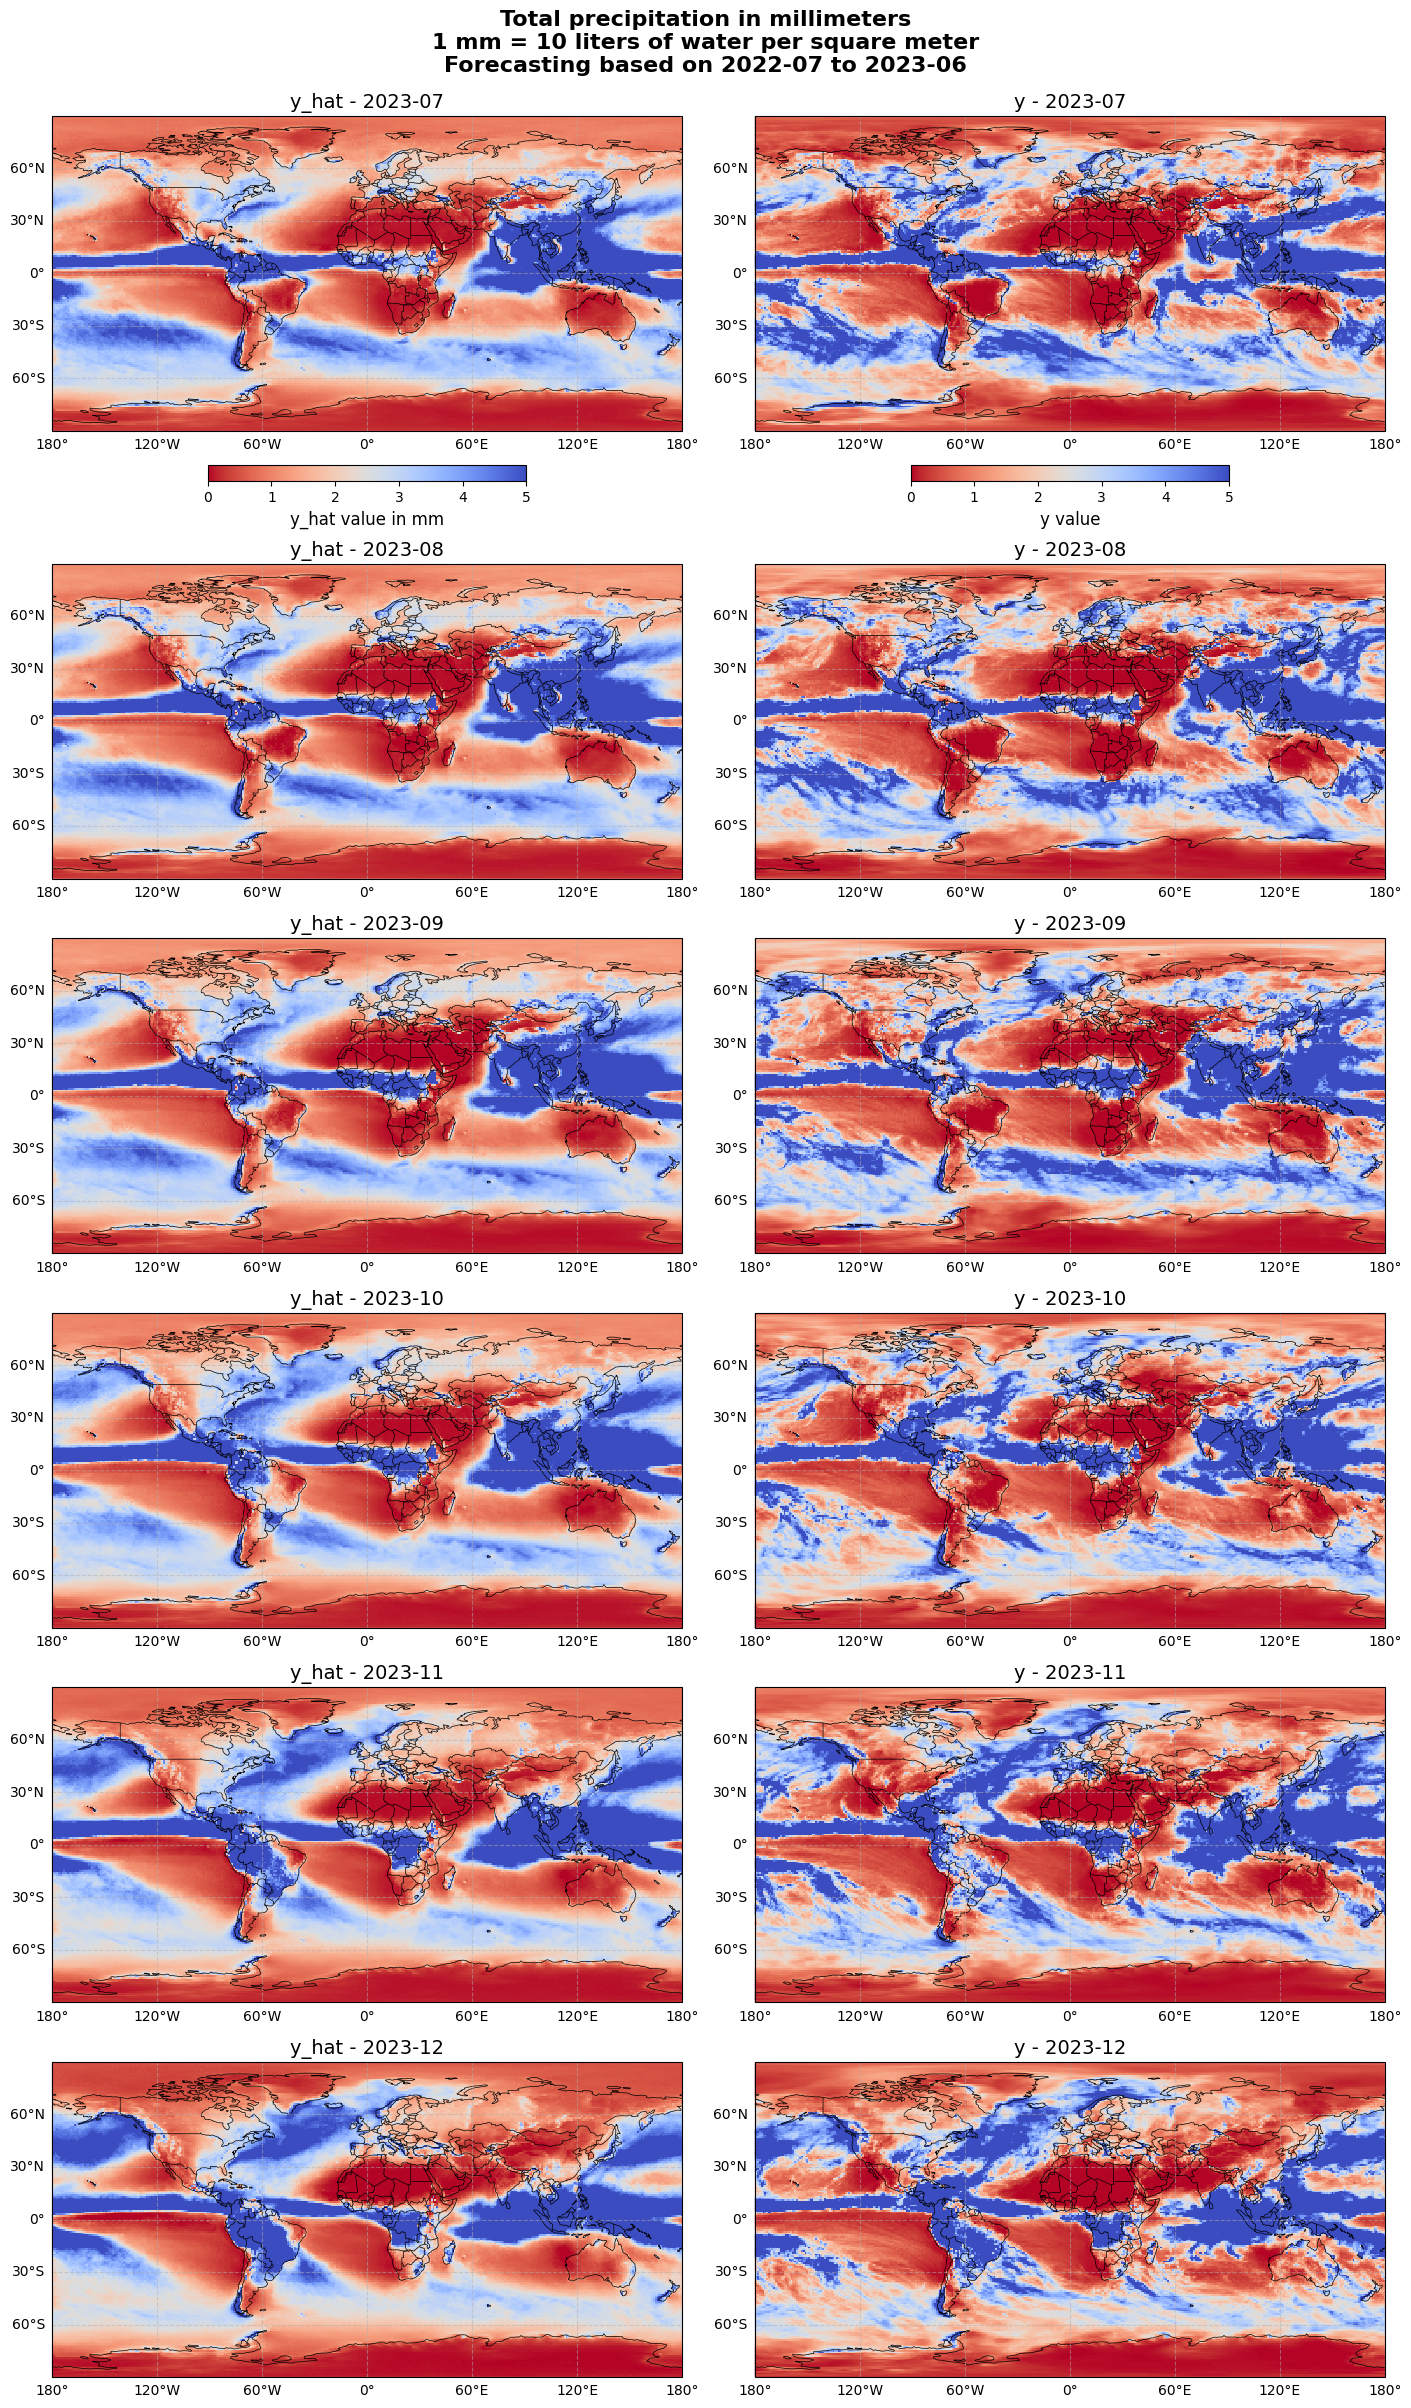

In [12]:
plot_full_horizon(
    ds_pred,
    forecast_time="2023-06-01",  # Specify the desired forecast_time
    y_hat="y_hat",
    y="y",
    vmin=0,
    vmax=5,
    colormap="coolwarm_r"
)


In [33]:
import xarray as xr
import os
import glob

# Define the preprocess function
def preprocess(file_path):
    """
    Preprocess a single dataset:
    - Load the dataset.
    - Extract the crop name from the file path.
    - Keep only the 'croparea' variable.
    - Rename 'croparea' to include the crop name.
    - Remove attributes to avoid conflicts.

    Args:
        file_path (str): Path to the NetCDF file.

    Returns:
        xarray.Dataset: Preprocessed dataset.
    """
    # Load the dataset
    ds = xr.open_dataset(file_path, chunks="auto")
    
    # Extract crop name from filename
    file_name = os.path.basename(file_path)
    crop_name = file_name.split("_")[-1].split(".")[0]  # Extracts 'carrot'

    # Keep only 'croparea' and rename it
    ds = ds[['croparea']].rename_vars({'croparea': f'{crop_name}_croparea'})

    # Remove conflicting attributes
    ds.attrs = {}
    return ds

# Define the directory containing your NetCDF files
data_dir = '/teamspace/studios/this_studio/drought-forecasting/modeling-pipeline/data/01_raw/unzipped_files/CROPGRIDS/CROPGRIDSv1.08_NC_maps/CROPGRIDSv1.08_NC_maps/'

# Create a sorted list of file paths
file_list = sorted(glob.glob(data_dir + '*.nc'))

# Exclude specific file
excluded_file = 'Countries_2018.nc'
file_list = [file for file in file_list if not file.endswith(excluded_file)]

# Preprocess each file and combine them
datasets = [preprocess(file_path) for file_path in file_list]
crop_ds = xr.combine_by_coords(datasets, combine_attrs="override")

In [34]:
# Apply mask: Set values below 100 to 0, and values equal to or above 100 to 1
crop_ds = crop_ds.map(lambda da: xr.where(da >= 1, 1, 0))

# Step 1: Adjust longitude for crop_ds
crop_ds = crop_ds.assign_coords(lon=((crop_ds.lon + 360) % 360)).sortby('lon')

In [35]:
import xarray as xr

def mask_with_crop_area(ds: xr.Dataset, crop_ds: xr.Dataset, variable: str, crop: str) -> xr.Dataset:
    """
    Interpolates `crop_ds` to match `ds` using Dask, then masks a variable in `ds` with a crop area from `crop_ds`.
    Creates a new variable in `ds` with the masked values.

    Args:
        ds (xr.Dataset): Dataset containing the variable to mask.
        crop_ds (xr.Dataset): Dataset containing crop area variables.
        variable (str): Name of the variable in `ds` to mask.
        crop (str): Specific crop variable to use for masking (e.g., 'cotton_croparea').

    Returns:
        xr.Dataset: Dataset with a new variable containing the masked values.

    Raises:
        ValueError: If the specified variable or crop is not found in the datasets.
    """
    if variable not in ds:
        raise ValueError(f"Variable '{variable}' not found in the dataset `ds`.")

    # Unify chunks for consistent Dask operations
    ds = ds.unify_chunks()
    crop_ds = crop_ds.unify_chunks()

    # Check if the specific crop is in the crop dataset
    if crop not in crop_ds:
        raise ValueError(f"Crop variable '{crop}' not found in the dataset `crop_ds`.")

    # Use the specific crop area as the mask
    mask = crop_ds[crop]

    # Interpolate crop mask to match `ds` spatial resolution using Dask
    interpolated_mask = mask.interp(
        lat=ds.latitude, lon=ds.longitude, method="nearest"
    )

    # Mask the variable
    masked_variable = ds[variable].where(interpolated_mask > 0)

    # Add the masked variable as a new variable in the dataset
    masked_variable_name = f"{variable}_{crop}"
    ds[masked_variable_name] = masked_variable

    return ds


In [36]:
ds = mask_with_crop_area(ds_pred, crop_ds, "y", crop="maize_croparea")
ds = mask_with_crop_area(ds_pred, crop_ds, "y_hat", crop="maize_croparea")

In [37]:
ds

<xarray.Dataset> Size: 659MB
Dimensions:               (forecast_time: 106, horizon: 6, latitude: 180,
                           longitude: 360)
Coordinates:
  * forecast_time         (forecast_time) datetime64[ns] 848B 2014-09-01 ... ...
  * horizon               (horizon) int64 48B 1 2 3 4 5 6
  * latitude              (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
  * longitude             (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
    lat                   (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
    lon                   (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
Data variables:
    y                     (forecast_time, horizon, latitude, longitude) float32 165MB ...
    y_hat                 (forecast_time, horizon, latitude, longitude) float32 165MB ...
    y_maize_croparea      (forecast_time, horizon, latitude, longitude) float32 165MB dask.array<chunksize=(106, 6, 180, 360), meta=np.ndarray>
    y_hat_maize_croparea  (forecast_time, horizon, latitude, longitude) float32 165MB dask.array<chunksize=(106, 6, 180, 360), meta=np.ndarray>

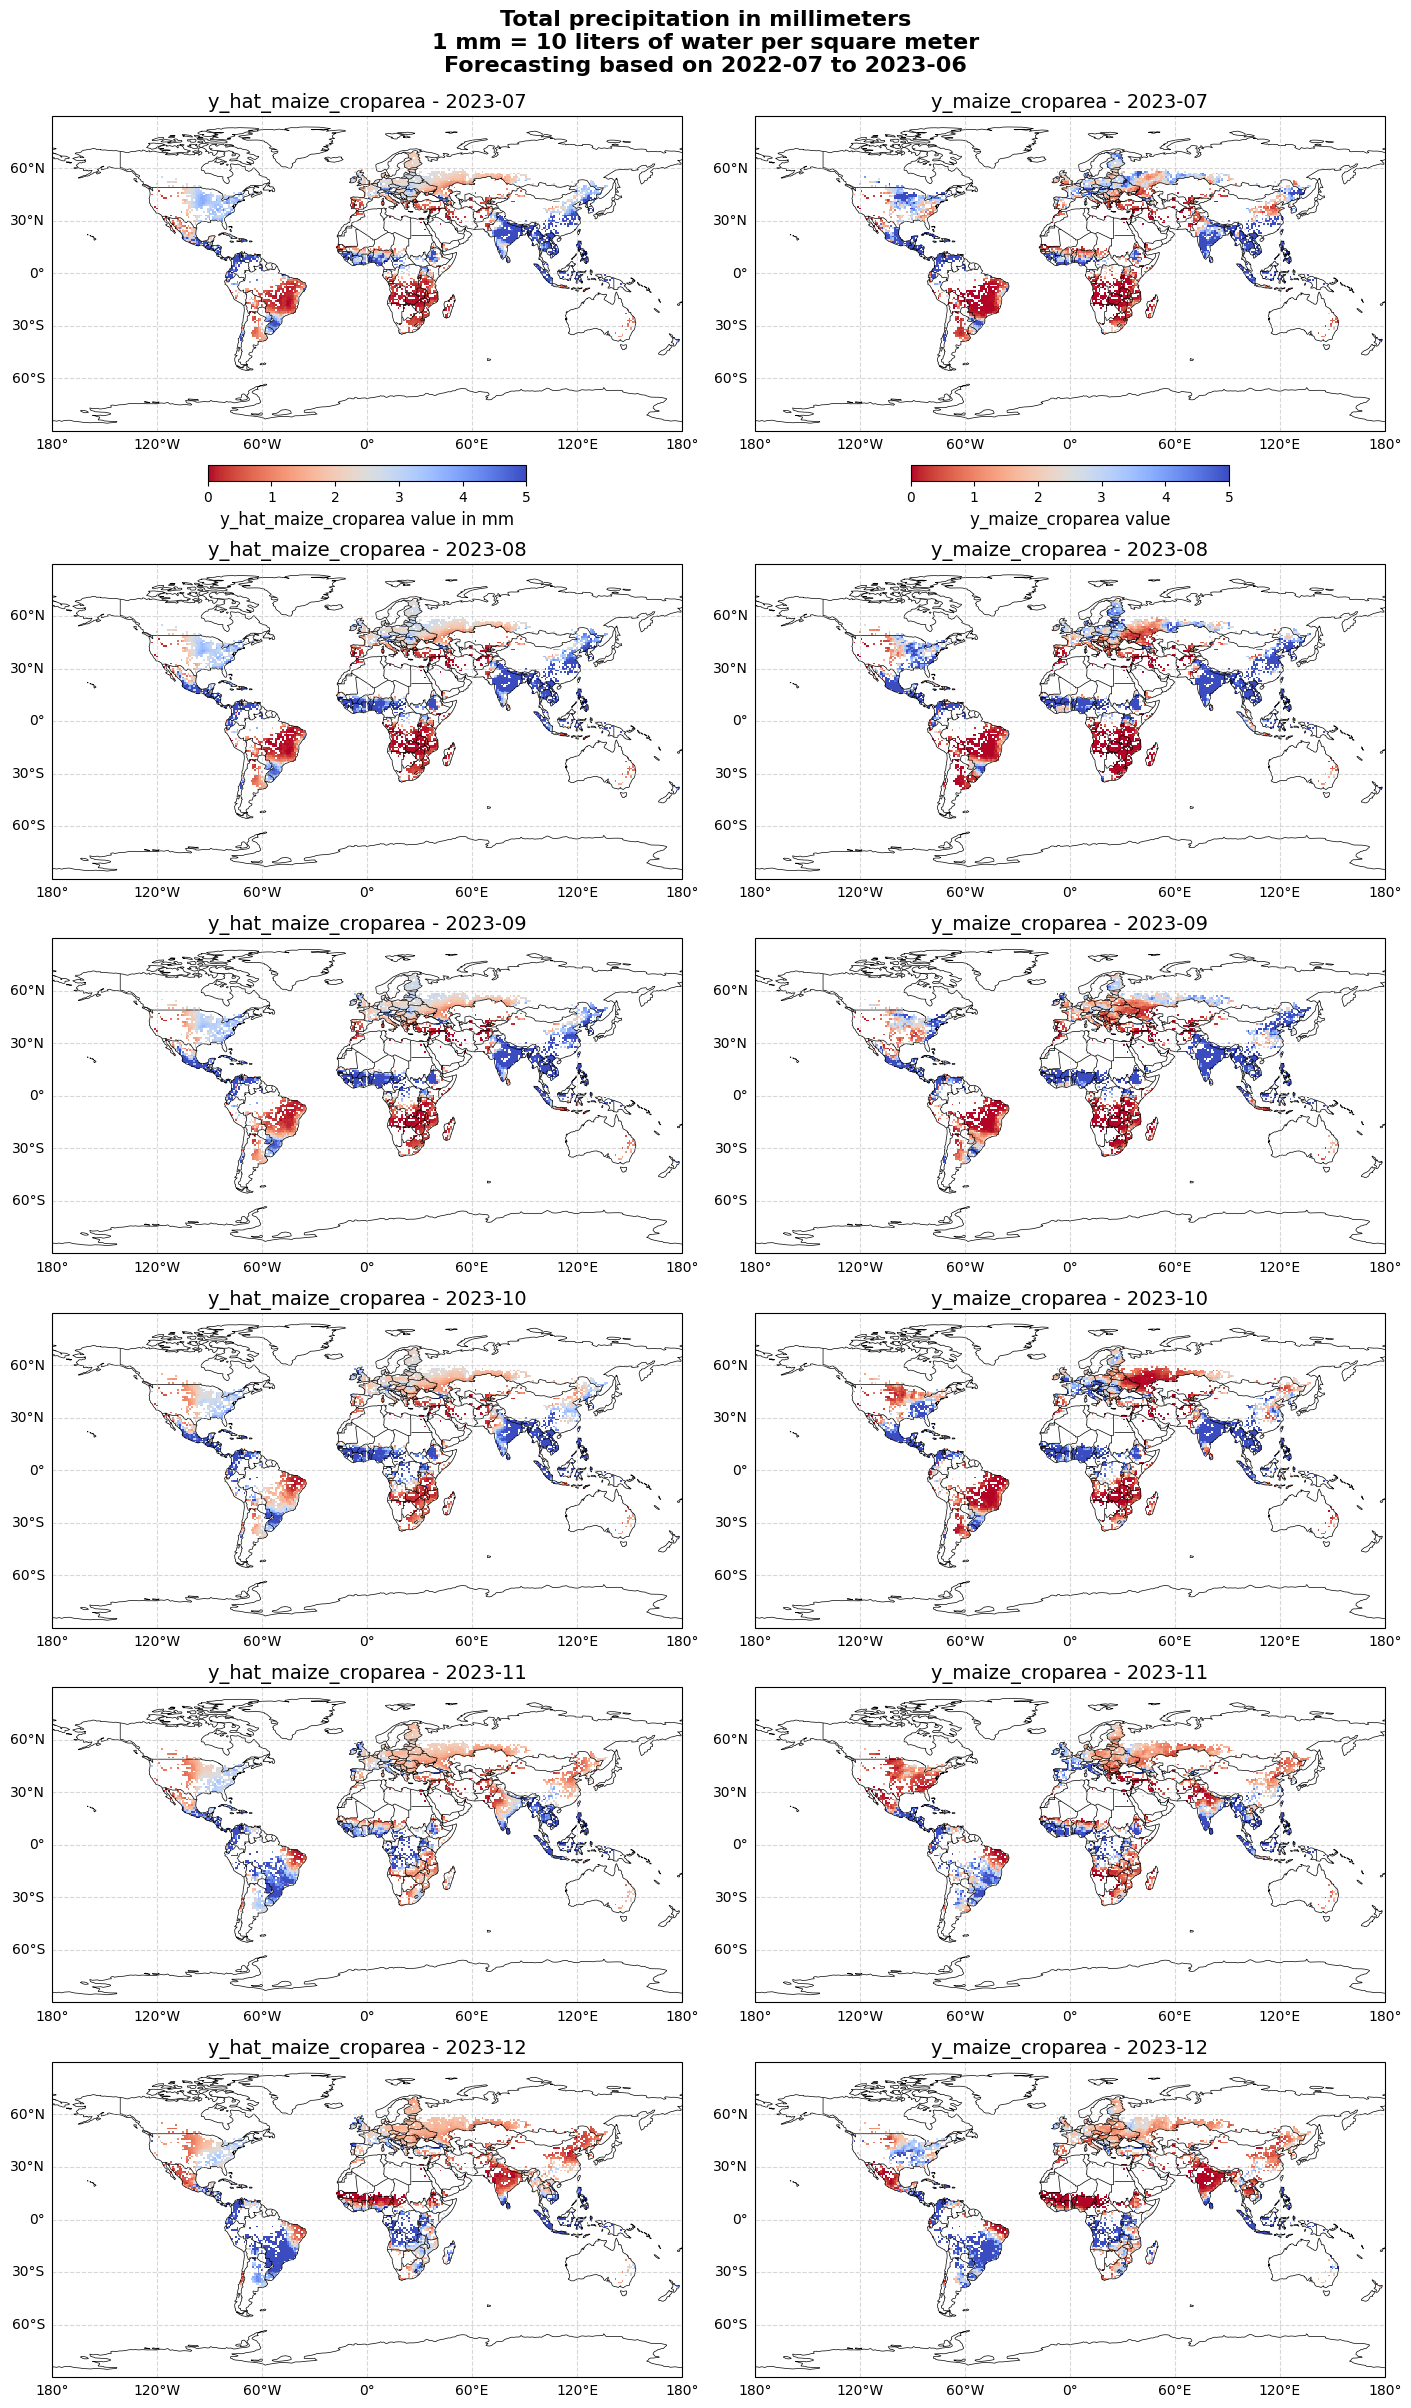

In [19]:
plot_full_horizon(
    ds,
    forecast_time="2023-06-01",  # Specify the desired forecast_time
    y_hat="y_hat_maize_croparea",
    y="y_maize_croparea",
    vmin=0,
    vmax=5,
    colormap="coolwarm_r"
)


In [20]:
import xarray as xr 
from typing import Tuple


ds = xr.open_dataset('drought-forecasting/modeling-pipeline/data/04_feature/features.nc', chunks="auto")


In [21]:
import xarray as xr
from typing import Tuple

def create_climatology(
    ds: xr.Dataset, 
    variable: str, 
    date_range: Tuple[str, str]
) -> xr.Dataset:
    """
    Generate climatology for a given variable over a specified date range.

    Args:
        ds (xr.Dataset): Input dataset containing the variable.
        variable (str): Variable name for which the climatology is to be calculated.
        date_range (Tuple[str, str]): Climatology period as (start_date, end_date).

    Returns:
        xr.Dataset: Dataset with the climatology added as a new variable.
    """
    # Ensure the variable exists
    if variable not in ds.variables:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")

    # Step 1: Filter dataset for the climatology period
    start_date, end_date = date_range
    ds_clim_period = ds.sel(valid_time=slice(start_date, end_date))

    # Step 2: Calculate monthly climatology mean for the specified variable
    data_clim_period = ds_clim_period[variable]
    climatology_mean = data_clim_period.groupby('valid_time.month').mean('valid_time')

    # Step 3: Add climatology to a new dataset
    climatology_ds = xr.Dataset()
    climatology_ds[f"{variable}_climatology"] = climatology_mean

    return climatology_ds

# Example usage
# Assuming `ds` is your xarray.Dataset
date_range = ("1991-01-01", "2020-12-31")
climatology = create_climatology(ds, variable='tp', date_range=date_range)


In [22]:
climatology

<xarray.Dataset> Size: 3MB
Dimensions:         (latitude: 180, longitude: 360, month: 12)
Coordinates:
  * latitude        (latitude) int64 1kB -90 -89 -88 -87 -86 ... 85 86 87 88 89
  * longitude       (longitude) int64 3kB 0 1 2 3 4 5 ... 355 356 357 358 359
  * month           (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tp_climatology  (month, latitude, longitude) float32 3MB dask.array<chunksize=(1, 176, 352), meta=np.ndarray>

In [39]:
ds

<xarray.Dataset> Size: 659MB
Dimensions:               (forecast_time: 106, horizon: 6, latitude: 180,
                           longitude: 360)
Coordinates:
  * forecast_time         (forecast_time) datetime64[ns] 848B 2014-09-01 ... ...
  * horizon               (horizon) int64 48B 1 2 3 4 5 6
  * latitude              (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
  * longitude             (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
    lat                   (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
    lon                   (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
Data variables:
    y                     (forecast_time, horizon, latitude, longitude) float32 165MB ...
    y_hat                 (forecast_time, horizon, latitude, longitude) float32 165MB ...
    y_maize_croparea      (forecast_time, horizon, latitude, longitude) float32 165MB dask.array<chunksize=(106, 6, 180, 360), meta=np.ndarray>
    y_hat_maize_croparea  (forecast_time, horizon, latitude, longitude) float32 165MB dask.array<chunksize=(106, 6, 180, 360), meta=np.ndarray>

In [47]:
import xarray as xr
import pandas as pd

def create_prediction_ds(ds: xr.Dataset, prediction_date: str) -> xr.Dataset:
    """
    Extracts a subset of the dataset for a given forecast time, converts 'horizon' to 'valid_time',
    and updates it to represent actual dates.

    Args:
        ds (xr.Dataset): The original xarray dataset containing multiple forecast times.
        prediction_date (str): The target forecast time in 'YYYY-MM-DD' format.

    Returns:
        xr.Dataset: A new dataset filtered for the given prediction date with 'valid_time' as actual dates.
    """
    # Ensure the prediction date exists in the dataset
    if prediction_date not in ds["forecast_time"].values.astype(str):
        raise ValueError(f"Prediction date {prediction_date} not found in dataset.")

    # Select the data for the given forecast time
    ds_selected = ds.sel(forecast_time=prediction_date)

    # Convert prediction_date to datetime
    prediction_date_dt = pd.to_datetime(prediction_date)

    # Generate valid_time dates based on forecast horizon
    valid_time_dates = [prediction_date_dt + pd.DateOffset(months=int(h)) for h in ds_selected["horizon"].values]

    # Assign the new coordinate 'valid_time' and drop 'horizon'
    ds_selected = ds_selected.assign_coords(valid_time=("horizon", valid_time_dates)).swap_dims({"horizon": "valid_time"}).drop_vars("horizon")

    return ds_selected

# Example usage:
new_ds = create_prediction_ds(ds, "2023-06-01T00:00:00.000000000")
# print(new_ds)


In [48]:
new_ds

<xarray.Dataset> Size: 6MB
Dimensions:               (valid_time: 6, latitude: 180, longitude: 360)
Coordinates:
    forecast_time         datetime64[ns] 8B 2023-06-01
  * latitude              (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
  * longitude             (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
    lat                   (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
    lon                   (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
  * valid_time            (valid_time) datetime64[ns] 48B 2023-07-01 ... 2023...
Data variables:
    y                     (valid_time, latitude, longitude) float32 2MB ...
    y_hat                 (valid_time, latitude, longitude) float32 2MB ...
    y_maize_croparea      (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(6, 180, 360), meta=np.ndarray>
    y_hat_maize_croparea  (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(6, 180, 360), meta=np.ndarray>

In [74]:
import xarray as xr
import numpy as np
import pandas as pd
from typing import Tuple

def integrate_climatology_with_prediction(
    new_ds: xr.Dataset, 
    climatology: xr.Dataset, 
    clim_variable: str = "tp_climatology",  # Climatology variable name
    pred_variable: str = "y"  # Prediction variable name
) -> xr.Dataset:
    """
    Integrates climatology with a prediction dataset by calculating the Percent of Normal.

    Args:
        new_ds (xr.Dataset): Dataset created from create_prediction_ds(), containing 'y'.
        climatology (xr.Dataset): Climatology dataset containing 'tp_climatology'.
        clim_variable (str, optional): Variable name in climatology dataset (default: 'tp_climatology').
        pred_variable (str, optional): Variable name in prediction dataset (default: 'y').

    Returns:
        xr.Dataset: Updated dataset with Percent of Normal for 'y'.
    """
    # Ensure 'y' exists in new_ds
    if pred_variable not in new_ds.variables:
        raise ValueError(f"Variable '{pred_variable}' not found in prediction dataset.")

    # Ensure 'tp_climatology' exists in climatology
    if clim_variable not in climatology.variables:
        raise ValueError(f"Climatology variable '{clim_variable}' not found in climatology dataset.")

    # Extract the 'y' variable from new_ds
    predicted_data = new_ds[pred_variable]

    # Ensure 'valid_time' exists in new_ds
    if "valid_time" not in new_ds.coords:
        raise ValueError("valid_time coordinate is missing in prediction dataset.")

    # Extract the corresponding month from 'valid_time'
    months = new_ds["valid_time"].dt.month

    # Select the climatology values for matching months
    climatology_mean = climatology[clim_variable].sel(month=months)

    # Replace zeros and NaNs in climatology to avoid division errors
    climatology_mean = climatology_mean.where(climatology_mean > 0, other=1e-10).fillna(1e-10)

    # Compute Percent of Normal: (y / tp_climatology) * 100
    percent_of_normal = xr.apply_ufunc(
        lambda y, clim: (y / clim) * 100,
        predicted_data,
        climatology_mean,
        dask="allowed"
    )

    # Add Percent of Normal to the prediction dataset
    new_ds_result = new_ds.copy()
    new_ds_result[f"{pred_variable}_percent_of_normal"] = percent_of_normal

    return new_ds_result


In [75]:
# Integrate climatology with prediction dataset
updated_ds = integrate_climatology_with_prediction(new_ds, climatology, clim_variable="tp_climatology", pred_variable="y")

In [76]:
updated_ds

<xarray.Dataset> Size: 8MB
Dimensions:               (valid_time: 6, latitude: 180, longitude: 360)
Coordinates:
    forecast_time         datetime64[ns] 8B 2023-06-01
  * latitude              (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
  * longitude             (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
    lat                   (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
    lon                   (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
  * valid_time            (valid_time) datetime64[ns] 48B 2023-07-01 ... 2023...
    month                 (valid_time) int64 48B 7 8 9 10 11 12
Data variables:
    y                     (valid_time, latitude, longitude) float32 2MB 0.417...
    y_hat                 (valid_time, latitude, longitude) float32 2MB 0.2 ....
    y_maize_croparea      (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(6, 180, 360), meta=np.ndarray>
    y_hat_maize_croparea  (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(6, 180, 360), meta=np.ndarray>
    y_percent_of_normal   (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 176, 352), meta=np.ndarray>

In [77]:
updated_ds = integrate_climatology_with_prediction(updated_ds, climatology, clim_variable="tp_climatology", pred_variable="y_hat")

In [78]:
updated_ds

<xarray.Dataset> Size: 9MB
Dimensions:                  (valid_time: 6, latitude: 180, longitude: 360)
Coordinates:
    forecast_time            datetime64[ns] 8B 2023-06-01
  * latitude                 (latitude) int64 1kB -90 -89 -88 -87 ... 87 88 89
  * longitude                (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
    lat                      (latitude) int64 1kB -90 -89 -88 -87 ... 87 88 89
    lon                      (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
  * valid_time               (valid_time) datetime64[ns] 48B 2023-07-01 ... 2...
    month                    (valid_time) int64 48B 7 8 9 10 11 12
Data variables:
    y                        (valid_time, latitude, longitude) float32 2MB 0....
    y_hat                    (valid_time, latitude, longitude) float32 2MB 0....
    y_maize_croparea         (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(6, 180, 360), meta=np.ndarray>
    y_hat_maize_croparea     (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(6, 180, 360), meta=np.ndarray>
    y_percent_of_normal      (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 176, 352), meta=np.ndarray>
    y_hat_percent_of_normal  (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(1, 176, 352), meta=np.ndarray>

In [84]:
import torch
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from typing import Any, Optional
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_full_horizon(
    ds: xr.Dataset,
    valid_time: Optional[str] = None,
    y_hat: str = "y_hat",
    y: str = "y",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    colormap: str = "custom"
) -> Any:
    """
    Visualize y_hat and y_true for all horizon steps for a specific valid_time
    using a selectable color scale. The maps are projected with PlateCarree and
    country boundaries/coastlines are added via Cartopy.
    
    Args:
        ds (xarray.Dataset):
            The dataset containing 'y' and 'y_hat' variables with dimensions:
            (valid_time, latitude, longitude).
        valid_time (str, optional):
            Date (in 'YYYY-MM-DD' format) of the valid_time coordinate to visualize.
            Defaults to None, which selects the first valid_time.
        y_hat (str, optional):
            Name of the variable representing model predictions. Defaults to "y_hat".
        y (str, optional):
            Name of the variable representing ground truth. Defaults to "y".
        vmin (float, optional):
            Minimum value for color scaling. Defaults to None.
        vmax (float, optional):
            Maximum value for color scaling. Defaults to None.
        colormap (str, optional):
            Colormap for visualization. Defaults to "custom".
    
    Returns:
        Any: The resulting figure with subplots showing y_hat and y_true for each valid_time step.
    
    Raises:
        ValueError: If the dataset does not contain the specified 'y' or 'y_hat' variables.
        ValueError: If the provided valid_time is not found in the dataset.
    """
    # Validate dataset
    if not {y, y_hat}.issubset(ds.variables):
        raise ValueError(f"The dataset must contain '{y}' and '{y_hat}' variables.")
    
    # Validate and get the valid_time index
    if valid_time is not None:
        try:
            valid_time_idx = np.where(ds.valid_time == np.datetime64(valid_time))[0][0]
        except IndexError:
            raise ValueError(f"The provided valid_time '{valid_time}' is not found in the dataset.")
    else:
        valid_time_idx = 0  # Default to the first valid_time
    
    # Select colormap and normalization approach
    if colormap == "custom":
        custom_boundaries = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        custom_colors = ["red", "orange", "green", "lightblue", "blue"]
        cmap = ListedColormap(custom_colors)
        norm = BoundaryNorm(custom_boundaries, cmap.N)
    else:
        cmap = plt.get_cmap(colormap)
        norm = None
    
    # Extract data for the given valid_time
    y_hat_map = ds[y_hat].isel(valid_time=valid_time_idx).values
    y_true_map = ds[y].isel(valid_time=valid_time_idx).values
    
    # Coordinates
    lats = ds.latitude.values
    lons = ds.longitude.values
    valid_time_val = pd.to_datetime(ds.valid_time.values[valid_time_idx])
    valid_time_str = valid_time_val.strftime("%Y-%m")
    
    # Shift longitude from [0, 360] to [-180, 180] if necessary
    lons_shifted = np.where(lons > 180, lons - 360, lons)
    sorted_indices = np.argsort(lons_shifted)
    lons_sorted = lons_shifted[sorted_indices]
    
    # Compute vmin/vmax if not provided
    if vmin is None:
        vmin = min(np.nanmin(y_hat_map), np.nanmin(y_true_map))
    if vmax is None:
        vmax = max(np.nanmax(y_hat_map), np.nanmax(y_true_map))
    
    # Use Cartopy for plotting
    projection = ccrs.PlateCarree(central_longitude=0)
    fig, axes = plt.subplots(
        nrows=1, ncols=2, subplot_kw={"projection": projection}, figsize=(14, 6), constrained_layout=True
    )
    fig.suptitle(f"Soil Moisture Forecast for {valid_time_str}", fontsize=16, fontweight="bold")
    
    # --- Plot y_hat ---
    ax_hat = axes[0]
    ax_hat.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax_hat.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax_hat.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    
    mesh_hat = ax_hat.pcolormesh(
        lons_sorted, lats, y_hat_map[:, sorted_indices], cmap=cmap, norm=norm,
        vmin=vmin, vmax=vmax, shading="auto", transform=ccrs.PlateCarree()
    )
    ax_hat.set_title(f"Predicted {y_hat} - {valid_time_str}", fontsize=14)
    
    cbar_hat = plt.colorbar(mesh_hat, ax=ax_hat, orientation="horizontal", fraction=0.046, pad=0.04)
    cbar_hat.set_label(f"{y_hat} value", fontsize=12)
    
    # --- Plot y_true ---
    ax_true = axes[1]
    ax_true.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax_true.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax_true.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    
    mesh_true = ax_true.pcolormesh(
        lons_sorted, lats, y_true_map[:, sorted_indices], cmap=cmap, norm=norm,
        vmin=vmin, vmax=vmax, shading="auto", transform=ccrs.PlateCarree()
    )
    ax_true.set_title(f"Observed {y} - {valid_time_str}", fontsize=14)
    
    cbar_true = plt.colorbar(mesh_true, ax=ax_true, orientation="horizontal", fraction=0.046, pad=0.04)
    cbar_true.set_label(f"{y} value", fontsize=12)
    
    plt.show()
    # return fig


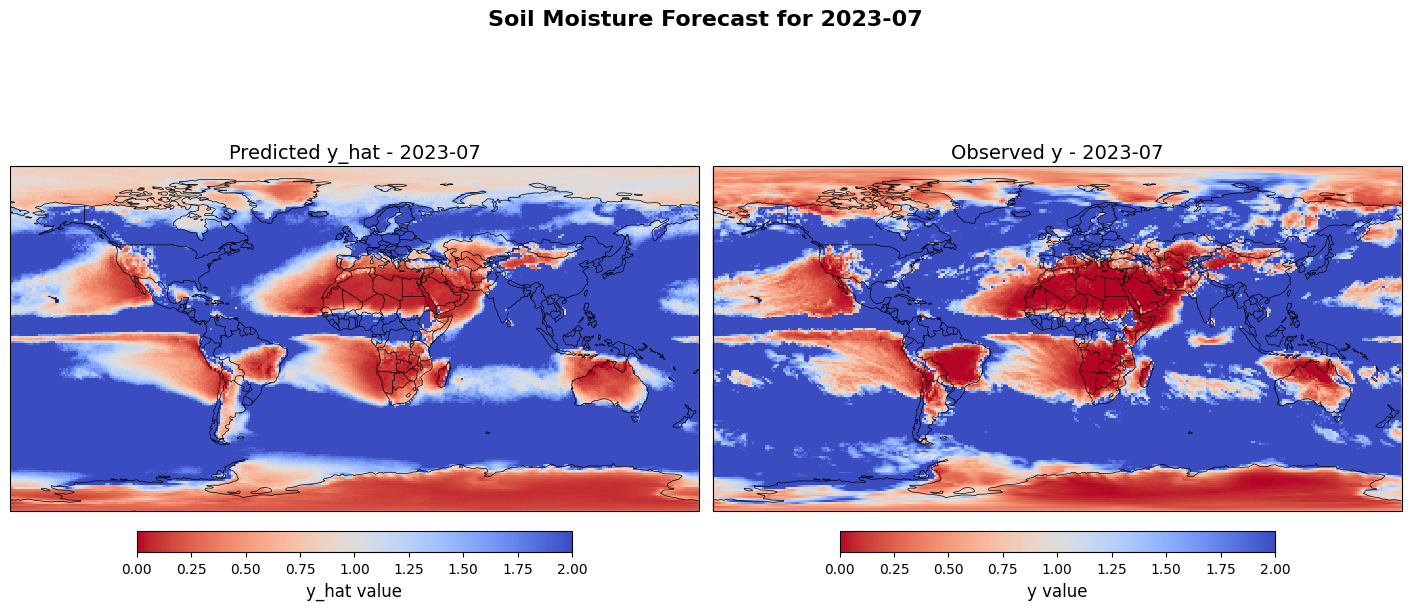

In [88]:
plot_full_horizon(
    ds=updated_ds, 
    valid_time="2023-07-01",  # Specify the forecast month you want to visualize
    y_hat="y_hat",  # Name of predicted values
    y="y",  # Name of observed values
    vmin=0,  # Optional: Set minimum value for color scaling
    vmax=2,  # Optional: Set maximum value for color scaling
    colormap="coolwarm_r"  # Use a predefined colormap (e.g., "viridis", "coolwarm") or "custom"
)
